In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
RANDOM_SEED = 42

Using TensorFlow backend.


# Load Dataset

In [2]:
dataset_path = './data/HASC/'
activity_folders = os.listdir(dataset_path)
print(activity_folders)

data_frame = pd.DataFrame()
df_list = []

for i in range(len(activity_folders)):
    activity_folder = activity_folders[i]
    print(activity_folder)
    
    person_folder_path = dataset_path + activity_folder + '/'
    person_folders = os.listdir(person_folder_path)
    
    for j in range(len(person_folders)):
        person_folder = person_folders[j]
        #print(person_folder)
        
        csv_file_path = dataset_path + activity_folder + '/' + person_folder + '/'
        csv_files = os.listdir(csv_file_path)
        
        for k in range(len(csv_files)):
            csv_file = csv_files[k]
            #print(csv_file)
            
            df = pd.read_csv(csv_file_path + '/' + csv_file, index_col=None, header=None)
            df['Activity'] = activity_folder
            df_list.append(df)
        
data_frame = pd.concat(df_list, axis = 0, sort= True, ignore_index = True)
data_frame.columns = ['Timestamp', 'Ax', 'Ay', 'Az', 'Activity']

['Jogging', 'Sit_Down', 'Skip', 'Stand_Up', 'Stay', 'Walk']
Jogging
Sit_Down
Skip
Stand_Up
Stay
Walk


In [3]:
print(data_frame.count())
data_frame.head()

Timestamp    593233
Ax           593233
Ay           593233
Az           593233
Activity     593233
dtype: int64


,Timestamp,Ax,Ay,Az,Activity
0,10122.863440,0.618271,-1.966354,0.961472,Jogging
1,10122.934788,0.457809,-1.044403,0.726517,Jogging
2,10122.944823,0.724289,-0.825272,0.512680,Jogging
3,10122.954857,0.762573,-0.568726,0.249176,Jogging
4,10122.964863,0.736816,-0.304901,0.134369,Jogging


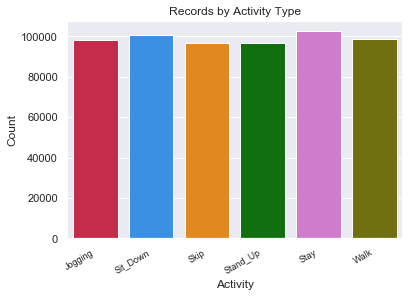

In [4]:
colours = ["crimson", "dodgerblue", "darkorange", "green", "orchid", "olive", "lightseagreen", "violet"]
sns.set(rc={'figure.figsize':(6, 4)})
fig = sns.countplot(x = "Activity" , data = data_frame, palette=colours)
fig.set_xticklabels(fig.get_xticklabels(), rotation=30, ha="right", fontsize = 9)
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Records by Activity Type")
#plt.grid(True)
plt.show(fig)

# Normalize Training Data

In [5]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

data_frame['Ax'] = data_frame['Ax'] / data_frame['Ax'].max()
data_frame['Ay'] = data_frame['Ay'] / data_frame['Ay'].max()
data_frame['Az'] = data_frame['Az'] / data_frame['Az'].max()
# Round numbers
data_frame = data_frame.round({'Ax': 4, 'Ay': 4, 'Az': 4})

# Data Preprocessing

In [6]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []

for i in range(0, len(data_frame) - N_TIME_STEPS, step):
    xs = data_frame['Ax'].values[i: i + N_TIME_STEPS]
    ys = data_frame['Ay'].values[i: i + N_TIME_STEPS]
    zs = data_frame['Az'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data_frame['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [8]:
print(reshaped_segments.shape)
print(labels[0])

(29652, 200, 3)
[1. 0. 0. 0. 0. 0.]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
print('X_train : ', len(X_train))
print('y_train : ', len(y_train))
print('X_test : ', len(X_test))
print('y_test : ', len(y_test))

X_train :  23721
y_train :  23721
X_test :  5931
y_test :  5931


In [11]:
verbose = 1
epochs = 10
batch_size = 400

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  200
n_features :  3
n_outputs :  6


In [12]:
checkpoint = ModelCheckpoint("hasc_weights.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [13]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [14]:
# Load Weights
final_model = Model(inputs = model.input, outputs = model.output)
#final_model.load_weights('./har_weights.h5')
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks = [checkpoint], verbose=verbose)


# evaluate model
(loss, accuracy) = final_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 23721 samples, validate on 5931 samples
Epoch 1/10
23721/23721 [==============================] - 35s 1ms/step - loss: 0.7901 - acc: 0.6704 - val_loss: 0.4945 - val_acc: 0.7859

Epoch 00001: val_acc improved from -inf to 0.78587, saving model to hasc_weights.h5
Epoch 2/10
23721/23721 [==============================] - 38s 2ms/step - loss: 0.3948 - acc: 0.8381 - val_loss: 0.3362 - val_acc: 0.8862

Epoch 00002: val_acc improved from 0.78587 to 0.88619, saving model to hasc_weights.h5
Epoch 3/10
23721/23721 [==============================] - 35s 1ms/step - loss: 0.2617 - acc: 0.9005 - val_loss: 0.2491 - val_acc: 0.9300

Epoch 00003: val_acc improved from 0.88619 to 0.93003, saving model to hasc_weights.h5
Epoch 4/10
23721/23721 [==============================] - 33s 1ms/step - loss: 0.1823 - acc: 0.9375 - val_loss: 0.2456 - val_acc: 0.9057

Epoch 00004: val_acc did not improve from 0.93003
Epoch 5/10
23721/23721 [==============================] - 40s 2ms/step - loss: 0.1446 - acc

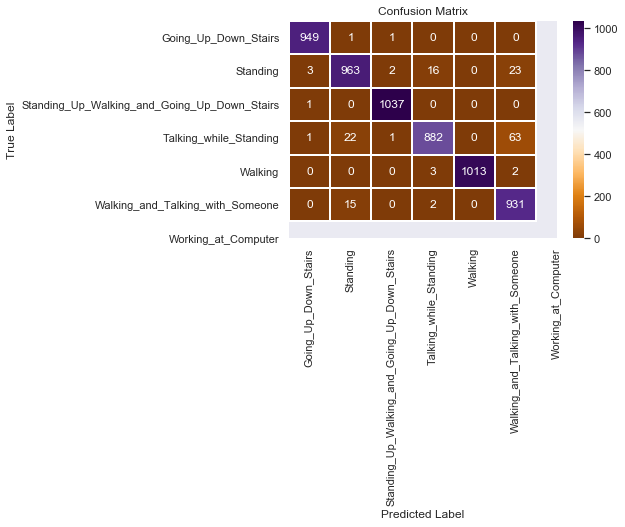

In [15]:

# Print confusion matrix for training data
y_pred_train = final_model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = ['Going_Up_Down_Stairs', 
          'Standing', 
          'Standing_Up_Walking_and_Going_Up_Down_Stairs', 
          'Talking_while_Standing', 
          'Walking', 
          'Walking_and_Talking_with_Someone', 
          'Working_at_Computer']

y_pred_test = final_model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='PuOr',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
